In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import datasets

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

mpl.rcParams["figure.figsize"] = (9,6)

# Yellowbrick &mdash; Clustering Evaluation Examples

The Yellowbrick library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. It extends the scikit-learn API with a new core object: the `Visualizer`. Visualizers allow models to be fit and transformed as part of the scikit-learn pipeline process, providing visual diagnostics throughout the transformation of high-dimensional data.

In machine learning, clustering models are unsupervised methods that attempt to detect patterns in unlabeled data. There are two primary classes of clustering algorithms: *agglomerative* clustering which links similar data points together, and *centroidal* clustering which attempts to find centers or partitions in the data.

Currently, Yellowbrick provides two visualizers to evaluate *centroidal* mechanisms, particularly K-Means clustering, that help users discover an optimal $K$ parameter in the clustering metric:
- `KElbowVisualizer`  visualizes the clusters according to a scoring function, looking for an "elbow" in the curve. 
- `SilhouetteVisualizer`  visualizes the silhouette scores of each cluster in a single model.

### Load the Data

For the following examples, we'll use the widely famous Iris dataset. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. You can learn more about it here: [Iris Data Set](https://archive.ics.uci.edu/ml/datasets/iris)

The dataset is loaded using scikit-learn's `datasets.load_iris()` function to create a sample two-dimensional dataset with 8 random clusters of points.

In [3]:
# Load iris flower dataset
iris = datasets.load_iris()

X = iris.data #clustering is unsupervised learning hence we load only X(i.e.iris.data) and not Y(i.e. iris.target)

### Let's have a look at the dataset

Before we dive into how this data can be evaluated efficiently using Yellowbrick, let's have a look at how the clusters actually look.

In [4]:
# Converting the data into dataframe
feature_names = iris.feature_names
iris_dataframe = pd.DataFrame(X, columns=feature_names)
iris_dataframe.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


### K-Means Algorithm
K-Means is a simple unsupervised machine learning algorithm that groups data into the number $K$ of clusters specified by the user, even if it is not the optimal number of clusters for the dataset. 

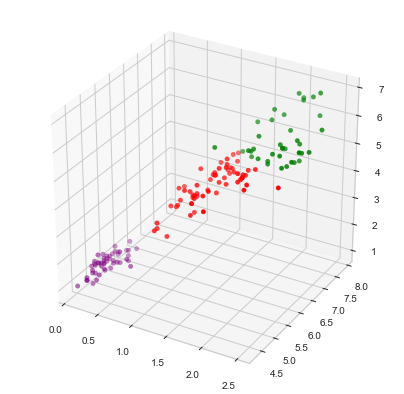

In [5]:
# Fitting the model with a dummy model, with 3 clusters (we already know there are 3 classes in the Iris dataset)
k_means = KMeans(n_clusters=3)
k_means.fit(X)

# Plotting a 3d plot using matplotlib to visualize the data points
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Setting the colors to match cluster results
colors = ['red' if label == 0 else 'purple' if label==1 else 'green' for label in k_means.labels_]

ax.scatter(X[:,3], X[:,0], X[:,2], c=colors)

In the above example plot, one of the clusters is linearly seperable and at a good seperation from other two clusters. Two of the clusters are close by and not linearly seperable.

Also the dataset is 4-dimensional i.e. it has 4 features, but for the sake of visualization using `matplotlib`, one of dimensions has been ignored. Therefore, it can be said that just visualization of data-points is not always enough for knowing optimal number of clusters $K$. 

## Elbow Method 

Yellowbrick's `KElbowVisualizer` implements the “elbow” method of selecting the optimal number of clusters by fitting the K-Means model with a range of values for $K$. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

In the following example, the `KElbowVisualizer` fits the model for a range of $K$ values from 2 to 10, which is set by the parameter `k=(2,11)`. When the model is fit with 3 clusters we can see an "elbow" in the graph, which in this case we know to be the optimal number since our dataset has 3 clusters of points. 

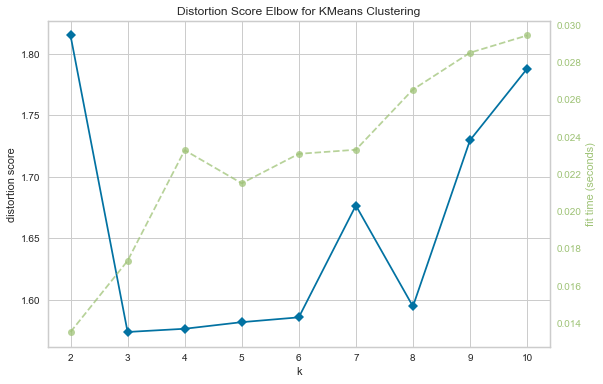

In [6]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

By default, the scoring parameter `metric` is set to `distortion`, which computes the sum of squared distances from each point to its assigned center. However, two other metrics can also be used with the `KElbowVisualizer`&mdash;`silhouette` and `calinski_harabaz`. The `silhouette` score is the mean silhouette coefficient for all samples, while the `calinski_harabaz` score computes the ratio of dispersion between and within clusters.
 
The `KElbowVisualizer` also displays the amount of time to fit the model per $K$, which can be hidden by setting `timings=False`. In the following example, we'll use the `calinski_harabaz` score and hide the time to fit the model.

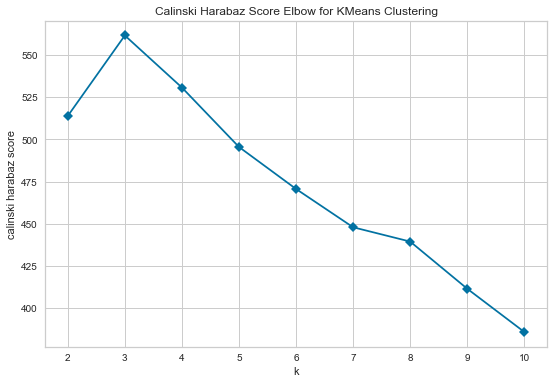

In [7]:
# Instantiate the clustering model and visualizer 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11), metric='calinski_harabaz', timings=False)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

It is important to remember that the Elbow method does not work well if the data is not very clustered. In such cases, you might see a smooth curve and the optimal value of $K$ will be unclear.

You can learn more about the Elbow method at Robert Grove's [Blocks](https://bl.ocks.org/rpgove/0060ff3b656618e9136b).

## Silhouette Visualizer 

Silhouette analysis can be used to evaluate the density and separation between clusters. The score is calculated by averaging the silhouette coefficient for each sample, which is computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between -1 and +1, where scores near +1 indicate high separation and scores near -1 indicate that the samples may have been assigned to the wrong cluster.

The `SilhouetteVisualizer` displays the silhouette coefficient for each sample on a per-cluster basis, allowing users to visualize the density and separation of the clusters. This is particularly useful for determining cluster imbalance or for selecting a value for $K$ by comparing multiple visualizers.

Since we created the sample dataset for these examples, we already know that the data points are grouped into 8 clusters. So for the first `SilhouetteVisualizer` example, we'll set $K$ to 3 in order to show how the plot looks when using the optimal value of $K$. 

Notice that graph contains homogeneous and long silhouettes. In addition, the vertical red-dotted line on the plot indicates the average silhouette score for all observations.

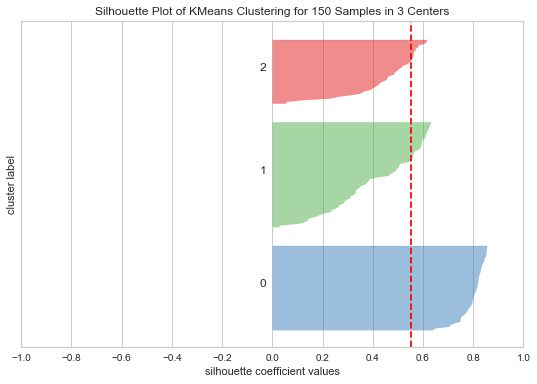

In [8]:
# Instantiate the clustering model and visualizer 
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

For the next example, let's see what happens when using a non-optimal value for $K$, in this case, 6. 

Now we see that the width of clusters 1 to 6 have become narrow, of unequal width and their silhouette coefficient scores have dropped. This occurs because the width of each silhouette is proportional to the number of samples assigned to the cluster. The model is trying to fit our data into a larger than optimal number of clusters, making some of the clusters narrower but much less cohesive as seen from the drop in average-silhouette score.

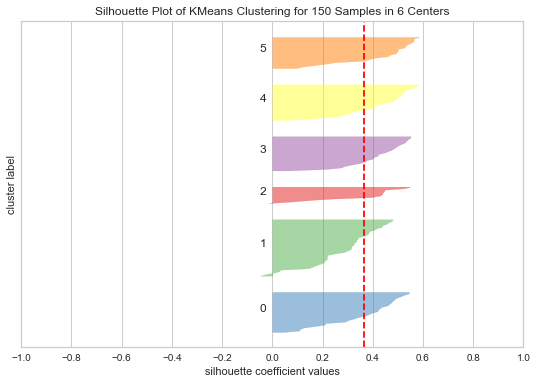

In [9]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data

## After Gopal's improvements to Silhouette Visualizer

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from yellowbrick.style import color_palette
from yellowbrick.cluster.base import ClusteringScoreVisualizer

from sklearn.metrics import silhouette_score, silhouette_samples


## Packages for export
__all__ = [
    "SilhouetteVisualizer"
]


##########################################################################
## Silhouette Method for K Selection
##########################################################################

class SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    model : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``).

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    Examples
    --------

    >>> from yellowbrick.cluster import SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, model, ax=None, **kwargs):
        super(SilhouetteVisualizer, self).__init__(model, ax=ax, **kwargs)

        # Visual Properties
        # TODO: Fix the color handling
        self.colormap = kwargs.get('colormap', 'set1')
        self.color = kwargs.get('color', None)

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        # Fit the wrapped estimator
        self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = self.estimator.n_clusters

        # Compute the scores of the cluster
        labels = self.estimator.predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self

    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10 # The bottom of the silhouette

        # Get the colors from the various properties
        # TODO: Use resolve_colors instead of this
        colors = color_palette(self.colormap, self.n_clusters_)

        # For each cluster, plot the silhouette scores
        for idx in range(self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster .
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.5
            )

            # Label the silhouette plots with their cluster numbers
            self.ax.text(-0.05, y_lower + 0.5 * size, str(idx))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_, color="red", linestyle="--"
        )

        return self.ax

    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title((
            "Silhouette Plot of {} Clustering for {} Samples in {} Centers"
        ).format(
            self.name, self.n_samples_, self.n_clusters_
        ))

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations

        # l_xlim and u_xlim are lower and upper limits of the x-axis,
        # set according to our calculated maximum and minimum silhouette score along with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_) - 0.1, 1)))
        u_xlim = min(1, round(max(self.silhouette_samples_) + 0.1, 1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks([])  # Clear the yaxis labels / ticks
        self.ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))  # Set the ticks at multiples of 0.1


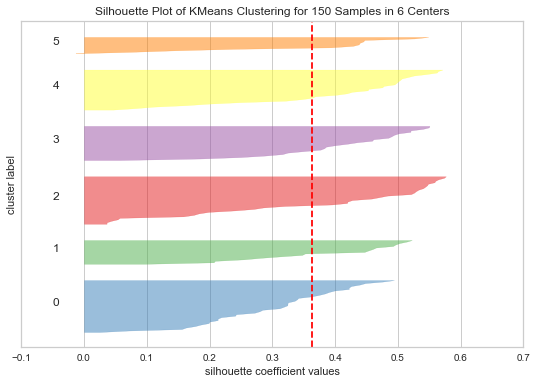

In [12]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/show the data